## <b>Style Transfer Tutorial</b>

* 원본 논문: [Image Style Transfer Using Convolutional Neural Networks (CVPR 2016)](https://rn-unison.github.io/articulos/style_transfer.pdf)
* 딥러닝을 활용한 <b>스타일 전송(style transfer)</b> 방법을 처음으로 제안한 논문입니다.
    * 이미지 자체를 업데이트하는 이미지 최적화(optimization) 기법 유형에 해당합니다.
* 소스코드를 실행하기 전에 **[런타임]** - **[런타임 유형 변경]** - **[GPU]**로 설정되어 있는지 확인합니다.
* 논문에서 제시한 파라미터를 완전히 동일하게 따르지는 않으며 핵심 아이디어를 이해하는 목적에 적합한 코드입니다.

#### <b>실습에 필요한 라이브러리 불러오기 및 환경 설정</b>

In [4]:
# 필요한 PyTorch 라이브러리 불러오기
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models

import PIL
import matplotlib.pyplot as plt

import copy

In [5]:
# GPU 장치 사용 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
# 이미지를 불러와 다운받아 텐서(Tensor) 객체로 변환하는 함수
def image_loader(img_path, imsize):
    loader = transforms.Compose([
        transforms.Resize(imsize), # 이미지의 크기를 변경
        transforms.ToTensor() # torch.Tensor 형식으로 변경 [0, 255] → [0, 1]
    ])
    image = PIL.Image.open(img_path)
    # 네트워크 입력에 들어갈 이미지에 배치 목적의 차원(dimension) 추가
    image = loader(image).unsqueeze(0)
    # print(image.shape)
    return image.to(device, torch.float) # GPU로 올리기


# torch.Tensor 형태의 이미지를 화면에 출력하는 함수
def imshow(tensor):
    # matplotlib는 CPU 기반이므로 CPU로 옮기기
    image = tensor.cpu().clone()
    # torch.Tensor에서 사용되는 배치 목적의 차원(dimension) 제거
    image = image.squeeze(0)
    # PIL 객체로 변경 
    image = transforms.ToPILImage()(image)
    # 이미지를 화면에 출력(matplotlib는 [0, 1] 사이의 값이라고 해도 정상적으로 처리)
    plt.imshow(image)
    plt.show()

In [7]:
# 저장소의 소스코드를 다운로드하여 실습용 이미지 준비하기
!git clone https://github.com/ndb796/Deep-Learning-Paper-Review-and-Practice
%cd Deep-Learning-Paper-Review-and-Practice

Cloning into 'Deep-Learning-Paper-Review-and-Practice'...
remote: Enumerating objects: 462, done.
remote: Counting objects: 100% (201/201), done.
remote: Compressing objects: 100% (199/199), done.
remote: Total 462 (delta 73), reused 7 (delta 2), pack-reused 261
Receiving objects: 100% (462/462), 53.82 MiB | 26.65 MiB/s, done.
Resolving deltas: 100% (153/153), done.
/content/Deep-Learning-Paper-Review-and-Practice


#### <b>Image Reconstruction 실습하기</b>

* 이미지를 최적화(optimization)한다는 것은 특정 손실 값을 낮추는 방향으로 이미지를 업데이트하는 것을 의미합니다.
* MSE 손실(loss)을 이용해 임의의 노이즈(noise)를 특정한 이미지로 변환해 봅시다.

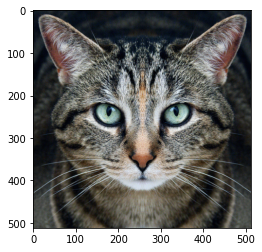

In [8]:
# 목표 이미지(target image) 불러오기
img_path = './code_practices/images/cat.jpg'
target_image = image_loader(img_path, (512, 512))
imshow(target_image)

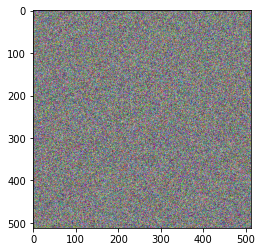

In [9]:
# 동일한 크기의 노이즈 이미지 준비하기
noise = torch.empty_like(target_image).uniform_(0, 1).to(device)
imshow(noise)

[ Start ]


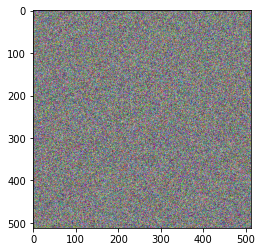

[ Step: 10 ]
Loss: 0.10425548255443573


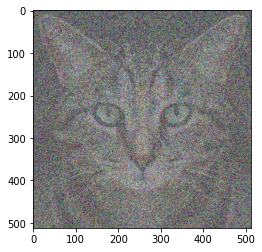

[ Step: 20 ]
Loss: 0.06227990239858627


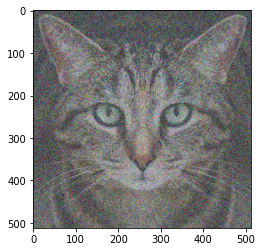

[ Step: 30 ]
Loss: 0.037204623222351074


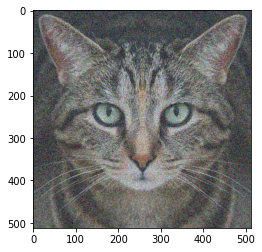

[ Step: 40 ]
Loss: 0.022225216031074524


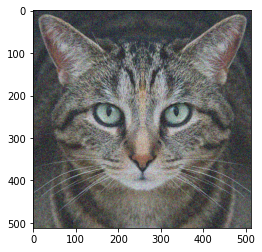

[ Step: 50 ]
Loss: 0.013276848010718822


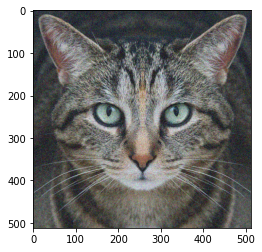

[ Step: 60 ]
Loss: 0.007931294851005077


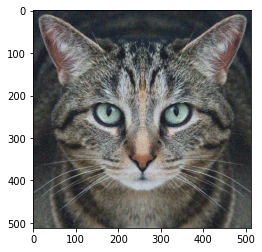

[ Step: 70 ]
Loss: 0.0047379788011312485


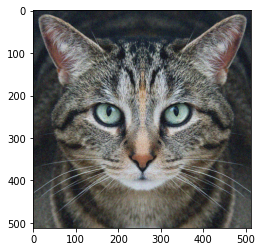

[ Step: 80 ]
Loss: 0.002830362878739834


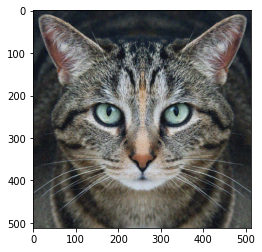

[ Step: 90 ]
Loss: 0.0016907959943637252


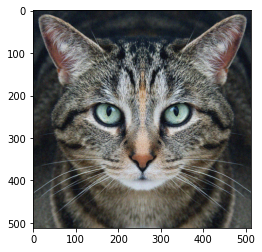

[ Step: 100 ]
Loss: 0.001010043895803392


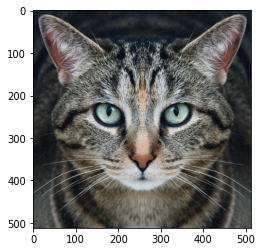

In [10]:
loss = nn.MSELoss() # 손실(loss) 함수 설정
iters = 100 # 반복(iteration) 횟수 설정
lr = 1e4

print("[ Start ]")
imshow(noise)

for i in range(iters):
    # required_grad 속성의 값을 True로 설정하여 해당 torch.Tensor의 연산을 추적
    noise.requires_grad = True

    # 손실 함수에 대하여 미분하여 기울기(gradient) 계산
    output = loss(noise, target_image)
    output.backward()

    # 계산된 기울기(gradient)를 이용하여 손실 함수가 감소하는 방향으로 업데이트
    gradient = lr * noise.grad
    # 결과적으로 노이즈(perturbation)의 각 픽셀의 값이 [-eps, eps] 사이의 값이 되도록 자르기
    noise = torch.clamp(noise - gradient, min=0, max=1).detach_() # 연산을 추적하는 것을 중단하기 위해 detach() 호출

    if (i + 1) % 10 == 0:
        print(f'[ Step: {i + 1} ]')
        print(f'Loss: {output}')
        imshow(noise)

#### <b>실습을 위한 이미지 불러오기</b>

* 빈센트 반 고흐의 그림과 건물 사진을 불러옵니다.

[ Content Image ]


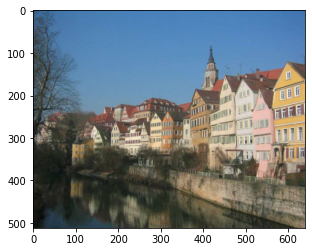

[ Style Image ]


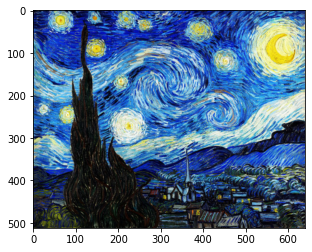

In [11]:
# 콘텐츠(Content) 이미지와 스타일(Style) 이미지를 모두 준비합니다.
content_img = image_loader('./code_practices/images/content_img_1.jpg', (512, 640))
style_img = image_loader('./code_practices/images/style_img_1.jpg', (512, 640))

print("[ Content Image ]")
imshow(content_img)
print("[ Style Image ]")
imshow(style_img)

#### <b>CNN 네트워크 불러오기</b>

* 특징 추출기(feature extractor)로 VGG 네트워크를 사용합니다.

In [12]:
# 뉴럴 네트워크 모델을 불러옵니다.
cnn = models.vgg19(pretrained=True).features.to(device).eval()
print(cnn)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [13]:
# 입력 정규화(Normalization)를 위한 초기화
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = mean.clone().view(-1, 1, 1)
        self.std = std.clone().view(-1, 1, 1)

    def forward(self, img):
        return (img - self.mean) / self.std

#### <b>Style Reconstruction 실습하기</b>

* 임의의 노이즈(noise)가 특정한 이미지의 스타일을 가지도록 변환합니다.
* style_layers 리스트 변수의 값을 조절하여 어떤 레이어를 이용할지 설정할 수 있습니다.

In [14]:
def gram_matrix(input):
    # a는 배치 크기, b는 특징 맵의 개수, (c, d)는 특징 맵의 차원을 의미
    a, b, c, d = input.size()
    # 논문에서는 i = 특징 맵의 개수, j = 각 위치(position)
    features = input.view(a * b, c * d)
    # 행렬 곱으로 한 번에 Gram 내적 계산 가능
    G = torch.mm(features, features.t())
    # Normalize 목적으로 값 나누기
    return G.div(a * b * c * d)


# 스타일 손실(style loss) 계산을 위한 클래스 정의
class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

In [15]:
style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

# 스타일 손실(style loss)을 계산하는 함수
def get_style_losses(cnn, style_img, noise_image):
    cnn = copy.deepcopy(cnn)
    normalization = Normalization(cnn_normalization_mean, cnn_normalization_std).to(device)
    style_losses = []
    
    # 가장 먼저 입력 이미지가 입력 정규화(input normalization)를 수행하도록
    model = nn.Sequential(normalization)
    # 현재 CNN 모델에 포함되어 있는 모든 레이어를 확인하며
    i = 0
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        # 설정한 style layer까지의 결과를 이용해 style loss를 계산
        if name in style_layers:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature) # 값이 아니라 클래스임
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # 마지막 style loss 이후의 레이어는 사용하지 않도록
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]
    return model, style_losses

In [16]:
def style_reconstruction(cnn, style_img, input_img, iters):
    model, style_losses = get_style_losses(cnn, style_img, input_img)
    optimizer = optim.LBFGS([input_img.requires_grad_()])

    print("[ Start ]")
    imshow(input_img)

    # 하나의 값만 이용하기 위해 배열 형태로 사용
    run = [0]
    while run[0] <= iters:

        def closure():
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0

            for sl in style_losses:
                style_score += sl.loss

            style_score *= 1e6
            style_score.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print(f"[ Step: {run[0]} / Style loss: {style_score.item()}]")
                imshow(input_img)
            
            return style_score
        
        optimizer.step(closure)

    # 결과적으로 이미지의 각 픽셀의 값이 [0, 1] 사이의 값이 되도록 자르기
    input_img.data.clamp_(0, 1)

    return input_img

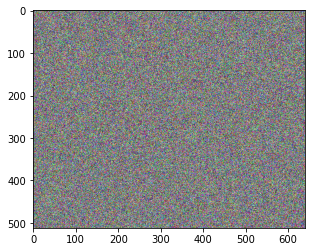

In [17]:
# 콘텐츠 이미지와 동일한 크기의 노이즈 이미지 준비하기
input_img = torch.empty_like(content_img).uniform_(0, 1).to(device)
imshow(input_img)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[ Start ]


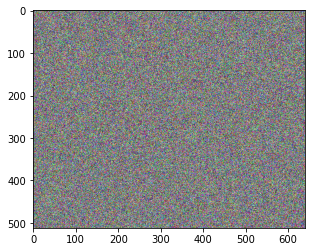

[ Step: 50 / Style loss: 421.03997802734375]


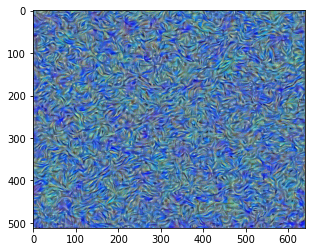

[ Step: 100 / Style loss: 102.13764953613281]


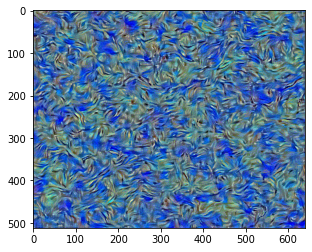

[ Step: 150 / Style loss: 49.29974365234375]


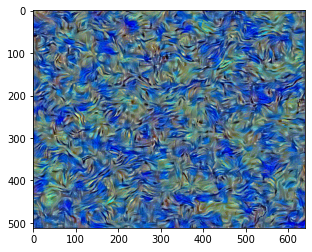

[ Step: 200 / Style loss: 35.91655731201172]


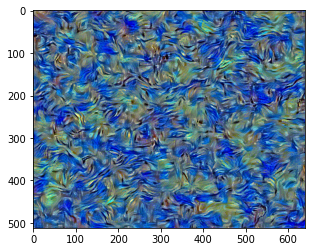

[ Step: 250 / Style loss: 28.304840087890625]


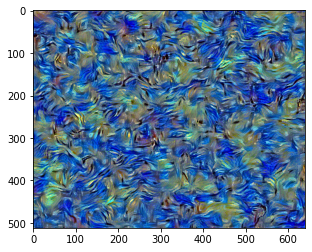

[ Step: 300 / Style loss: 23.183412551879883]


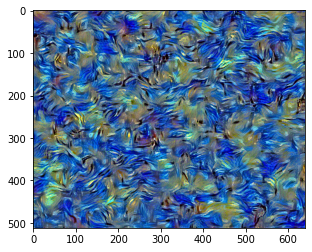

In [18]:
# style reconstruction 수행
output = style_reconstruction(cnn, style_img=style_img, input_img=input_img, iters=300)

#### <b>Content Reconstruction 실습하기</b>

* 임의의 노이즈(noise)가 특정한 이미지의 콘텐츠를 가지도록 변환합니다.

In [19]:
# 콘텐츠 손실(content loss) 계산을 위한 클래스 정의
class ContentLoss(nn.Module):
    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

In [20]:
content_layers = ['conv_4']

# 콘텐츠 손실(content loss)을 계산하는 함수
def get_content_losses(cnn, content_img, noise_image):
    cnn = copy.deepcopy(cnn)
    normalization = Normalization(cnn_normalization_mean, cnn_normalization_std).to(device)
    content_losses = []
    
    # 가장 먼저 입력 이미지가 입력 정규화(input normalization)를 수행하도록
    model = nn.Sequential(normalization)

    # 현재 CNN 모델에 포함되어 있는 모든 레이어를 확인하며
    i = 0
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        # 설정한 content layer까지의 결과를 이용해 content loss를 계산
        if name in content_layers:
            target_feature = model(content_img).detach()
            content_loss = ContentLoss(target_feature)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

    # 마지막 content loss 이후의 레이어는 사용하지 않도록
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss):
            break

    model = model[:(i + 1)]
    return model, content_losses

In [21]:
def content_reconstruction(cnn, content_img, input_img, iters):
    model, content_losses = get_content_losses(cnn, content_img, input_img)
    optimizer = optim.LBFGS([input_img.requires_grad_()])

    print("[ Start ]")
    imshow(input_img)

    # 하나의 값만 이용하기 위해 배열 형태로 사용
    run = [0]
    while run[0] <= iters:

        def closure():
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            content_score = 0

            for cl in content_losses:
                content_score += cl.loss

            content_score.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print(f"[ Step: {run[0]} / Content loss: {content_score.item()}]")
                imshow(input_img)
            
            return content_score
        
        optimizer.step(closure)

    # 결과적으로 이미지의 각 픽셀의 값이 [0, 1] 사이의 값이 되도록 자르기
    input_img.data.clamp_(0, 1)

    return input_img

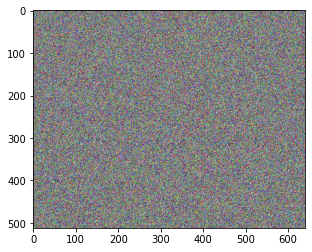

In [22]:
# 콘텐츠 이미지와 동일한 크기의 노이즈 이미지 준비하기
input_img = torch.empty_like(content_img).uniform_(0, 1).to(device)
imshow(input_img)

[ Start ]


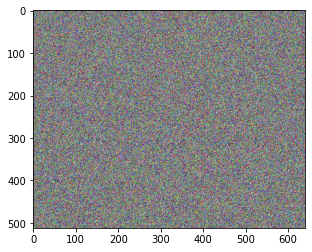

[ Step: 50 / Content loss: 0.7494770884513855]


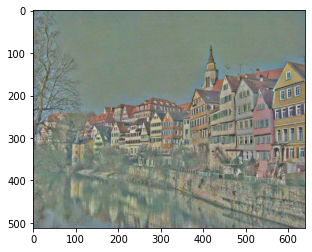

[ Step: 100 / Content loss: 0.37852323055267334]


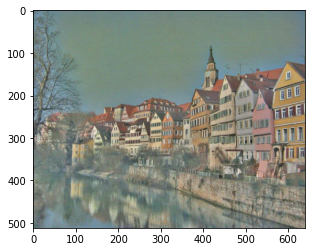

[ Step: 150 / Content loss: 0.24645879864692688]


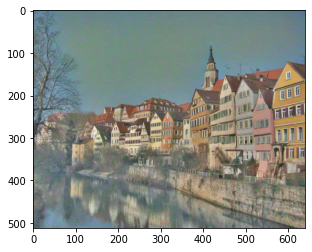

[ Step: 200 / Content loss: 0.17772577702999115]


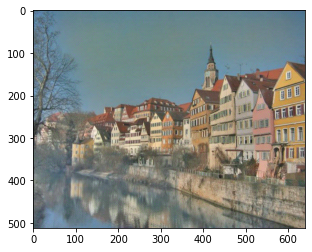

[ Step: 250 / Content loss: 0.13622240722179413]


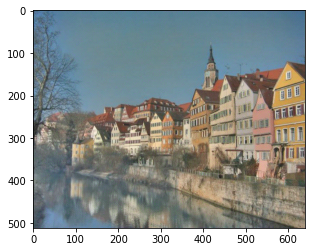

[ Step: 300 / Content loss: 0.1066879853606224]


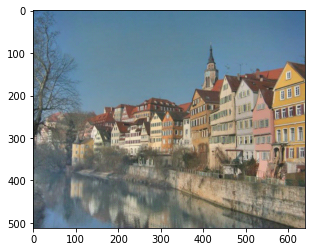

In [23]:
# content reconstruction 수행
output = content_reconstruction(cnn, content_img=content_img, input_img=input_img, iters=300)

#### <b>Style Transfer 실습하기 ①</b>

* Content Loss와 Style Loss를 함께 이용하여 Style Transfer를 진행합니다.

In [ ]:
content_layers = ['conv_4']
style_layers = ['conv_1', 'conv_3', 'conv_5', 'conv_7', 'conv_9']

# Style Transfer 손실(loss)을 계산하는 함수
def get_losses(cnn, content_img, style_img, noise_image):
    cnn = copy.deepcopy(cnn)
    normalization = Normalization(cnn_normalization_mean, cnn_normalization_std).to(device)
    content_losses = []
    style_losses = []
    
    # 가장 먼저 입력 이미지가 입력 정규화(input normalization)를 수행하도록
    model = nn.Sequential(normalization)

    # 현재 CNN 모델에 포함되어 있는 모든 레이어를 확인하며
    i = 0
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        # 설정한 content layer까지의 결과를 이용해 content loss를 계산
        if name in content_layers:
            target_feature = model(content_img).detach()
            content_loss = ContentLoss(target_feature)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        # 설정한 style layer까지의 결과를 이용해 style loss를 계산
        if name in style_layers:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # 마지막 loss 이후의 레이어는 사용하지 않도록
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]
    return model, content_losses, style_losses

In [ ]:
def style_transfer(cnn, content_img, style_img, input_img, iters):
    model, content_losses, style_losses = get_losses(cnn, content_img, style_img, input_img)
    optimizer = optim.LBFGS([input_img.requires_grad_()])

    print("[ Start ]")
    imshow(input_img)

    # 하나의 값만 이용하기 위해 배열 형태로 사용
    run = [0]
    while run[0] <= iters:

        def closure():
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            content_score = 0
            style_score = 0

            for cl in content_losses:
                content_score += cl.loss
            for sl in style_losses:
                style_score += sl.loss

            style_score *= 1e5
            loss = content_score + style_score
            loss.backward()

            run[0] += 1
            if run[0] % 100 == 0:
                print(f"[ Step: {run[0]} / Content loss: {content_score.item()} / Style loss: {style_score.item()}]")
                imshow(input_img)
            
            return content_score + style_score
        
        optimizer.step(closure)

    # 결과적으로 이미지의 각 픽셀의 값이 [0, 1] 사이의 값이 되도록 자르기
    input_img.data.clamp_(0, 1)

    return input_img

In [ ]:
# 콘텐츠(Content) 이미지와 스타일(Style) 이미지를 모두 준비합니다.
content_img = image_loader('./code_practices/images/content_img_1.jpg', (512, 640))
style_img = image_loader('./code_practices/images/style_img_1.jpg', (512, 640))

print("[ Content Image ]")
imshow(content_img)
print("[ Style Image ]")
imshow(style_img)